<a href="https://colab.research.google.com/github/AndresMontesDeOca/Redes_Neuronales/blob/main/05_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularización L1 y L2 - Predicción de Energía
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Fuentes/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Data/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################

Mounted at /content/drive/


In [48]:
# Función para crear y compilar el modelo
def create_model(regularizer=None):
    model = Sequential([
        Dense(30, activation='relu', kernel_regularizer=regularizer, input_shape=(X_train.shape[1],)),
        Dense(20, activation='relu', kernel_regularizer=regularizer),
        Dense(1)
    ])
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

# # Definición de las funciones
# ################################################################
# import keras.backend as K

# def r2_score(y_true, y_pred):
#     SS_res =  K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return 1 - SS_res/(SS_tot + K.epsilon())
# #############################################################################
# def compile_model(new_model, loss, optimizer):
#     new_model.compile(optimizer=optimizer, loss=loss, metrics=['mae', r2_score])
#     print(new_model.summary())
#     return new_model
# #############################################################################
# def MyModel(loss, optimizer, input_dim, output_dim):
#     new_model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_dim,)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(output_dim)
#     ])
#     return compile_model(new_model, loss, optimizer)
# #############################################################################
# def MyCallbacks(patience):
#     early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
#     return [early_stop]
# #############################################################################

In [52]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1, l2

# Definir el tamaño del batch
batch_size = 32
epochs = 150

# División de los datos en conjuntos de entrenamiento y validación
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_tmp, y_train_tmp, test_size=0.4, random_state=42)

# Escalado de los datos
data_scaler, target_scaler = StandardScaler(), StandardScaler()
X_train_scaled = data_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
X_valid_scaled = data_scaler.transform(X_valid)
X_test_scaled = data_scaler.transform(X_test)
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Definir la función para crear el modelo
def create_model(regularizer=None):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizer),
        Dense(64, activation='relu', kernel_regularizer=regularizer),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Entrenar y evaluar el modelo sin regularización
start_time = time.time()
model_no_reg = create_model()
history_no_reg = model_no_reg.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid_scaled), verbose=0)
time_no_reg = time.time() - start_time

# Entrenar y evaluar el modelo con regularización L1
start_time = time.time()
model_l1 = create_model(regularizer=l1(0.01))
history_l1 = model_l1.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid_scaled), verbose=0)
time_l1 = time.time() - start_time

# Entrenar y evaluar el modelo con regularización L2
start_time = time.time()
model_l2 = create_model(regularizer=l2(0.01))
history_l2 = model_l2.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid_scaled), verbose=0)
time_l2 = time.time() - start_time

# Evaluar los modelos en el conjunto de prueba
test_results_no_reg = model_no_reg.evaluate(X_test_scaled, y_test_scaled, verbose=1)
test_results_l1 = model_l1.evaluate(X_test_scaled, y_test_scaled, verbose=1)
test_results_l2 = model_l2.evaluate(X_test_scaled, y_test_scaled, verbose=1)

# Crear un diccionario con los resultados
results = {
    'Model': ['No Regularization', 'L1 Regularization', 'L2 Regularization'],
    'Training Time (s)': [time_no_reg, time_l1, time_l2],
    'Test Loss': [test_results_no_reg[0], test_results_l1[0], test_results_l2[0]],
    'Test MAE': [test_results_no_reg[1], test_results_l1[1], test_results_l2[1]]
}

# Convertir el diccionario en un DataFrame
results_df = pd.DataFrame(results)

# Redondear los valores a dos decimales
results_df = results_df.round(2)

# Mostrar el DataFrame
display(results_df)


60/60 [==============================] - 0s 1ms/step - loss: 0.0631 - mean_absolute_error: 0.1867


,Model,Training Time (s),Test Loss,Test MAE
0,No Regularization,82.81,0.05,0.17
1,L1 Regularization,79.84,0.08,0.20
2,L2 Regularization,68.48,0.06,0.19


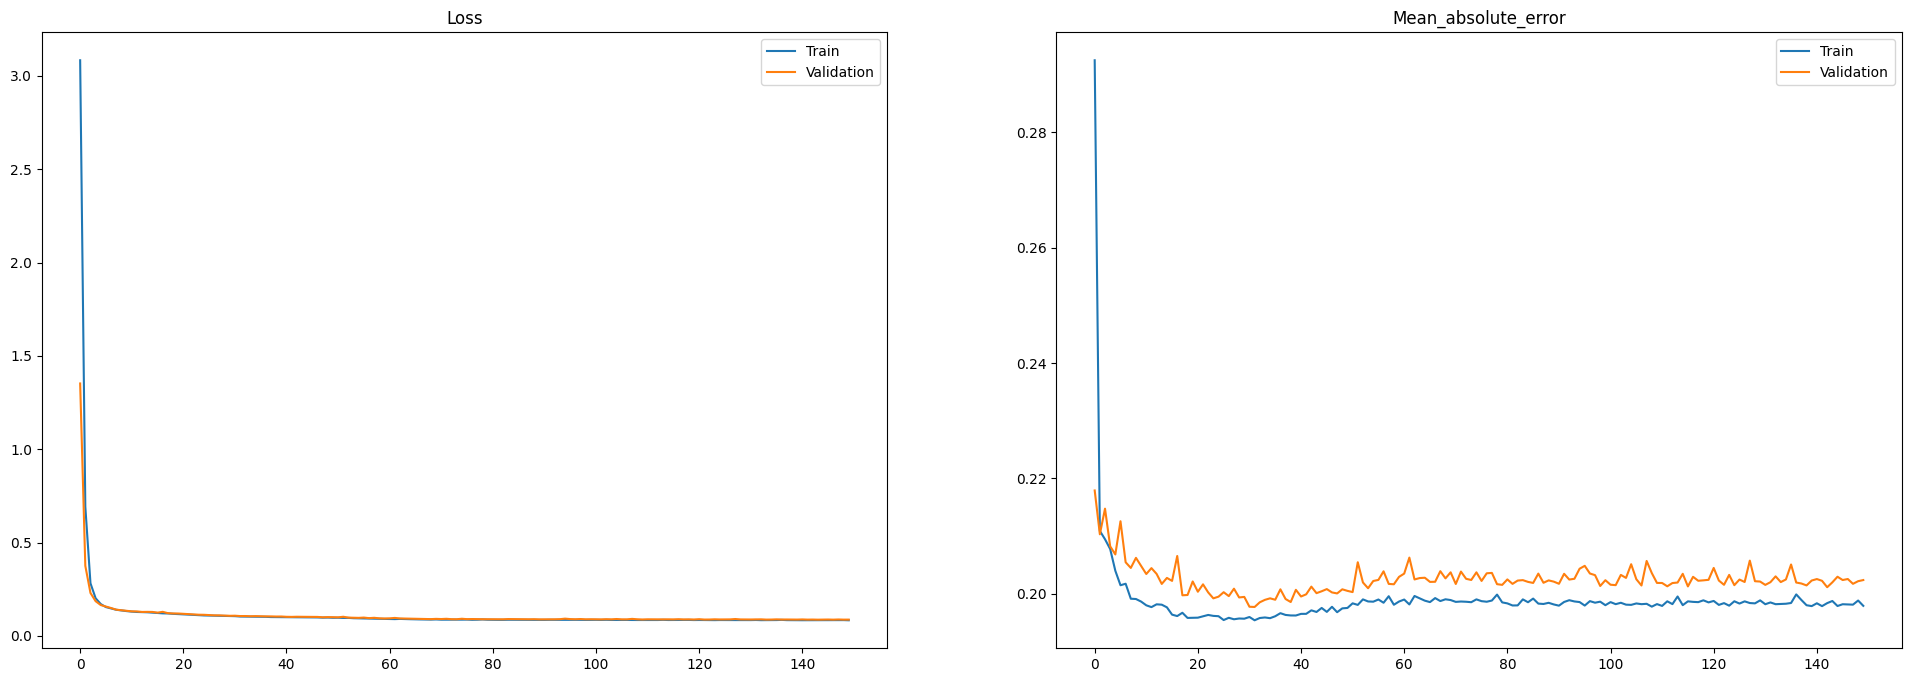

In [64]:
plot_history(history_l1
             )


### Carga del Dataset y selección de atributos numéricos

### Preparación de Datos
Selección de atributos. División en entrenamiento y prueba. Normalización

In [66]:
df = data
atr_pred = 'PE'
df_var = df.select_dtypes(include=[np.number]) # seleccion de atributos numericos del dataset
df_var = df_var.drop(atr_pred, axis=1) # elimina atributo a predecir

X = np.array(df_var)
T = np.array(df[atr_pred]).reshape((-1,1))

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.3, random_state=42)

# normalizacion de datos de entrada
data_scaler = StandardScaler()

X_train = data_scaler.fit_transform(X_train)
X_test = data_scaler.transform(X_test)

# normalización de atributo a predecir
target_scaler = StandardScaler()
T_train = target_scaler.fit_transform(T_train)
T_test = target_scaler.transform(T_test)


### Construccion del Modelo, entrenamiento y Evaluación
Se utilizan 3 modelos: sin regularización, con regularización L1 y con regularización L2. La función **crear_y_entrenar_modelo** genera un modelo y retorna el modelo, el historial y tiempo del entrenamiento y el error cuadrático medio sobre los datos de prueba

In [75]:
# funcion para simplificar la replica del regularizador
# espera la clase del regularizador o None si no se requiere
def crear_regulizador(regularizador):
    return None if regularizador is None else regularizador(0.001)

def crear_y_entrenar_modelo(regularizacion=None, epocas=150):

    # Sección de construccion del modelo
    activacion = 'relu'
    modelo = tf.keras.Sequential([
        Dense(30,
                     input_dim=X.shape[1],
                     activation=activacion,
                     kernel_regularizer=crear_regulizador(regularizacion)
                    ),
        Dense(20, activation=activacion,
                     kernel_regularizer=crear_regulizador(regularizacion)),
        Dense(1, activation='linear')
    ])

    ########################################################
    # completar: compilar modelo con sdg como optimizador y error cuadrático medio como funcion de pérdida


    # # Sección de entrenamiento del modelo
    # print('Entrenando -> ', end='')

    # segs = time.time() # tiempo de inicio en segundos

    # ########################################################
    # # completar: entrenar el modelo con 100 epocas, batch de 64 y validación de 40%
    # historial = # completar


    # segs = time.time()-segs # tiempo total en segundos

    # print('%.2f segundos' % segs)

    # ########################################################
    # # completar: calcular error cuadrático promedio y r2 score del modelo sobre datos de entrenamiento
    # mse = # completar
    # r2 = # completar

    # ########################################################
    # # calcular error cuadrático promedio y r2 score del modelo sobre datos de prueb
    # mse_test = # completar
    # r2_test = # completar

    # return (modelo, historial, segs, mse, mse_test, r2, r2_test)


# Crear, compilar y entrenar el modelo
# (modelo, historial, tpo, mse, mse_test, r2, r2_test) = crear_y_entrenar_modelo()
# (modelo_l1, historial_l1, tpo_l1, mse_l1, mse_test_l1, r2_l1, r2_test_l1) = crear_y_entrenar_modelo(regularizers.l1)
# (modelo_l2, historial_l2, tpo_l2, mse_l2, mse_test_l2, r2_l2, r2_test_l2) = crear_y_entrenar_modelo(regularizers.l2)

crear_y_entrenar_modelo()


### Gráficos de Evolución del Entrenamiento
Grafica función de pérdida para entrenamiento y validación en una subfigura

NameError: name 'historial' is not defined

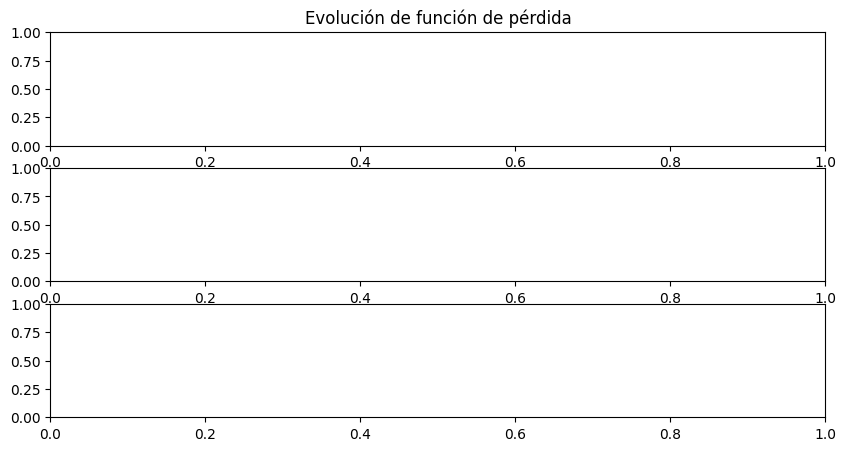

In [72]:
# history tiene el historial del entrenamiento, axs es una subfigura, y_lim son limites verticales para la subfigura
def dibujar_entrenamiento(history, axs=None, y_lim=None):

    # Pérdida
    axs.plot(history.history['loss'], label='Entrenamiento')
    axs.plot(history.history['val_loss'], label='Validación')
    axs.set_xlabel('Época')
    axs.set_ylim(y_lim)
    tick_frec = 5
    epocas = len(history.history['loss'])
    axs.set_xticks(np.arange(0, epocas, tick_frec))
    axs.set_xticklabels(np.arange(0, epocas, tick_frec))


fig, axs = plt.subplots(3, 1, figsize=(10, 5))
axs[0].set_title('Evolución de función de pérdida')


y_lim = np.max([historial.history['val_loss'],historial_l1.history['val_loss'],historial_l2.history['val_loss']])

dibujar_entrenamiento(historial, axs[0], (0, y_lim))
dibujar_entrenamiento(historial_l1, axs[1], (0, y_lim))
dibujar_entrenamiento(historial_l2, axs[2], (0, y_lim))

axs[0].legend()
plt.tight_layout()  # Ajustar el tamaño de la figura para dejar espacio para la leyenda
plt.show()

### En esta sección se obtienen los pesos para cada modelo y se grafican

In [ ]:
# pesos en un vector con los pesos del modelo, axs es una subfigura, y_lim son limites verticales para la subfigura
def graficar_pesos(pesos, ax, y_lim=(-1,1)):
    # Graficar los pesos
    ax.bar(range(0,len(pesos)), pesos, color='b', alpha=0.7)
    ax.set_xlabel('Índices de Pesos')
    ax.set_ylabel('Valor de Pesos')
    ax.set_title('Pesos de la primera capa')
    ax.set_ylim(y_lim)


# subfiguras para graficar los pesos de los modelos uno debajo de otro
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

#layer_id = 0
layer_id = 1
# obtiene pesos de los modelos
mod_w = modelo.layers[layer_id].get_weights()[0].flatten()
ml1_w = modelo_l1.layers[layer_id].get_weights()[0].flatten()
ml2_w = modelo_l2.layers[layer_id].get_weights()[0].flatten()


y_lim = np.max([np.abs(mod_w),np.abs(ml1_w), np.abs(ml2_w)]) # mismo limite para todas las subfiguras

graficar_pesos(mod_w, axs[0], (-y_lim, y_lim))
graficar_pesos(ml1_w, axs[1], (-y_lim, y_lim))
graficar_pesos(ml2_w, axs[2], (-y_lim, y_lim))

plt.tight_layout()
plt.show()

### Esta sección se muestran distintas estadísticas/metricas sobre el entrenamiento y los pesos del modelo

In [ ]:
# Esta sección se muestran distintas estadísticas/metricas sobre el entrenamiento y los pesos de cada modelo

print('Entrenamiento en segundos.....: %7.1f %7.1f %7.1f' % (tpo, tpo_l1, tpo_l2) )
print('Suma absoluta de pesos........: %7.4f %7.4f %7.4f' % ( np.sum(np.abs(mod_w)), np.sum(np.abs(ml1_w)), np.sum(np.abs(ml2_w))) )
###########################################################
# imprimir otras metricas

#Preguntas
 - Cómo es el tiempo de entrenamiento respecto del modelo con regularización respecto de sin regularización. ¿Por qué?

 - Observando las primeras épocas de las gráficas de las 3 funciones de pérdida de los entrenamientos de los modelos, indique las diferencias y justifique.

 - Grafique los pesos de la última capa oculta y realice algunas métricas sobre los pesos (suma y promedio absolutos, desviación, etc.). Marque las diferencias entre los 3 modelos e indique porque se dan.

 - La regularización es una herramienta útil para prevenir problemas de sobreajuste. ¿Percibe sobreajuste en los modelos? ¿En que beneficia o perjudica la regularización?
